# 1.2 Calculate H

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def compute_homography(image1points, image2points):
    num_points = image1points.shape[0]
    A = []
    for i in range(num_points):
        x, y = image1points[i][0], image1points[i][1]
        x_prime, y_prime = image2points[i][0], image2points[i][1]

        A.append([-x, -y, -1,  0,  0,  0, x_prime * x, x_prime * y, x_prime])
        A.append([ 0,  0,  0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

    A = np.array(A)

    U, S, Vt = np.linalg.svd(A) # SVD to sovle the total_least_squares problem
    h = Vt[-1] # smallest eigen value
    H = h.reshape(3, 3) # reshape
    H = H / H[2, 2] # Normalize

    return H

# 1.3 Wraping

Homography matrix H:
[[ 1.51248631e+00  4.96490002e-01 -6.90672243e+02]
 [ 3.67355939e-02  2.56502396e+00 -1.46913244e+03]
 [ 2.33783568e-06  2.99691807e-04  1.00000000e+00]]


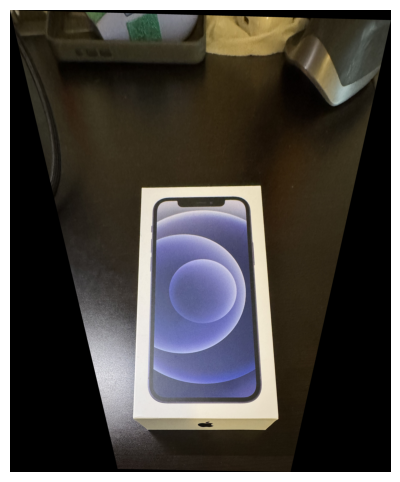

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def compute_homography(image1points, image2points):
    num_points = image1points.shape[0]
    A = []
    for i in range(num_points):
        x, y = image1points[i][0], image1points[i][1]
        x_prime, y_prime = image2points[i][0], image2points[i][1]

        A.append([-x, -y, -1,  0,  0,  0, x_prime * x, x_prime * y, x_prime])
        A.append([ 0,  0,  0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

    A = np.array(A)

    U, S, Vt = np.linalg.svd(A) # SVD to solve the total_least_squares problem
    h = Vt[-1] # smallest eigenvalue
    H = h.reshape(3, 3) # reshape
    H = H / H[2, 2] # Normalize

    return H

def perspective_transform(points, H):
    num_points = points.shape[0]
    homogeneous_points = np.hstack((points, np.ones((num_points, 1))))
    transformed_points = H @ homogeneous_points.T  # [3, N]
    transformed_points = transformed_points[:2, :] / transformed_points[2, :] # Normalize
    return transformed_points.T

def warp_image(image, image_b, H):
    h, w = image.shape[:2] # Shape
    h2, w2, _ = image_b.shape
    corners = np.array([ # four corners
        [0, 0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]
    ], dtype=np.float32)

    transformed_corners = perspective_transform(corners, H) # for output

    x_min, x_max = transformed_corners[:, 0].min(), max(transformed_corners[:, 0].max(), w2)
    y_min, y_max = transformed_corners[:, 1].min(), max(transformed_corners[:, 1].max(), h2)
    output_width = int(np.ceil(x_max - x_min))
    output_height = int(np.ceil(y_max - y_min))

    translation_matrix = np.array([ # make sure all the locations are positive
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])
    H_translated = translation_matrix @ H  
    
    warped_image = np.zeros((output_height, output_width, 3), dtype=np.uint8)

    x_coords, y_coords = np.meshgrid(np.arange(output_width), np.arange(output_height))
    homogeneous_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords).ravel()])
    # Reverse
    H_inv = np.linalg.inv(H_translated)
    source_coords = H_inv @ homogeneous_coords
    source_coords /= source_coords[2]  # Norm

    src_x = source_coords[0].reshape(output_height, output_width)
    src_y = source_coords[1].reshape(output_height, output_width)

    map_x = src_x.ravel()
    map_y = src_y.ravel()
    
    # Interpolation for all three RGB channels
    for i in range(3):  
        warped_image[..., i] = map_coordinates(image[..., i], [map_y, map_x], order=1, mode='constant', cval=0).reshape(output_height, output_width)

    return warped_image


img1 = cv2.imread('./iphone-1.jpeg')
img2 = cv2.imread('./iphone-2.jpeg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Select points on the image by Mouse
# plt.imshow(img1)
# plt.title('Click at least 4 points on Image 1')
# image1points = np.array(plt.ginput(n=-1, timeout=0))
# plt.close()

# plt.imshow(img2)
# plt.title('Click at least 4 points on Image 2')
# image2points = np.array(plt.ginput(n=-1, timeout=0))
# plt.close()

# for iphone
image1points = np.array([[ 918.04545455,  854.77272727],
 [2096.22727273,  837.31818182],
 [ 420.59090909, 3167.5       ],
 [2637.31818182, 3115.13636364]] )

image2points = np.array([[ 891.86363636,  601.68181818],
 [2305.68181818,  601.68181818],
 [ 778.40909091, 3420.59090909],
 [2497.68181818, 3411.86363636]])


# for phone case
# image1points = np.array([[ 996.59090909 ,1151.5],
#  [1869.31818182 ,1125.31818182],
#  [ 630.04545455 ,2844.59090909],
#  [2279.5        ,2835.86363636]])

# image2points = np.array([[1461.5        ,2101.31818182],
#  [2623.68181818 ,2126.04545455],
#  [1325.5        ,4858.40909091],
#  [2772.04545455 ,4858.40909091]])


# Compute the homography matrix
H = compute_homography(image1points, image2points)
print('Homography matrix H:')
print(H)

# Warp image and show the results
warped_image = warp_image(img1, img2, H)

plt.figure(figsize=(6, 6))
plt.imshow(warped_image)
plt.axis('off')
plt.show()


# 1.4 Forming Mosaics

Homography matrix H:
[[ 1.44191097e+00  7.51153698e-02 -2.51067698e+03]
 [ 3.21628649e-01  1.20911622e+00 -6.83900010e+02]
 [ 1.28095699e-04 -2.46005915e-05  1.00000000e+00]]


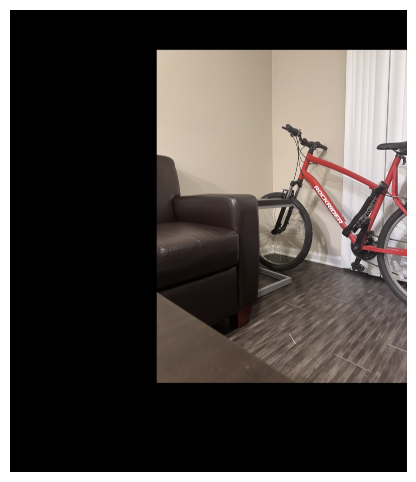

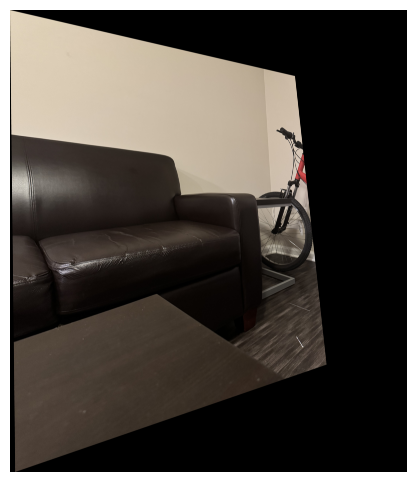

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def compute_homography(image1points, image2points):
    num_points = image1points.shape[0]
    A = []
    for i in range(num_points):
        x, y = image1points[i][0], image1points[i][1]
        x_prime, y_prime = image2points[i][0], image2points[i][1]

        A.append([-x, -y, -1,  0,  0,  0, x_prime * x, x_prime * y, x_prime])
        A.append([ 0,  0,  0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

    A = np.array(A)

    U, S, Vt = np.linalg.svd(A) # SVD to solve the total_least_squares problem
    h = Vt[-1] # smallest eigenvalue
    H = h.reshape(3, 3) # reshape
    H = H / H[2, 2] # Normalize

    return H

def perspective_transform(points, H):
    num_points = points.shape[0]
    homogeneous_points = np.hstack((points, np.ones((num_points, 1))))
    transformed_points = H @ homogeneous_points.T  # [3, N]
    transformed_points = transformed_points[:2, :] / transformed_points[2, :] # Normalize
    return transformed_points.T

def warp_image(image, image_b, H):
    h, w = image.shape[:2] # Shape
    h2, w2, _ = image_b.shape
    corners = np.array([ # four corners
        [0, 0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]
    ], dtype=np.float32)

    transformed_corners = perspective_transform(corners, H) # for output

    x_min, x_max = transformed_corners[:, 0].min(), max(transformed_corners[:, 0].max(), w2)
    y_min, y_max = transformed_corners[:, 1].min(), max(transformed_corners[:, 1].max(), h2)
    output_width = int(np.ceil(x_max - x_min))
    output_height = int(np.ceil(y_max - y_min))

    translation_matrix = np.array([ # make sure all the locations are positive
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])
    H_translated = translation_matrix @ H  
    
    warped_image = np.zeros((output_height, output_width, 3), dtype=np.uint8)

    x_coords, y_coords = np.meshgrid(np.arange(output_width), np.arange(output_height))
    homogeneous_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords).ravel()])
    # Reverse
    H_inv = np.linalg.inv(H_translated)
    source_coords = H_inv @ homogeneous_coords
    source_coords /= source_coords[2]  # Norm

    src_x = source_coords[0].reshape(output_height, output_width)
    src_y = source_coords[1].reshape(output_height, output_width)

    map_x = src_x.ravel()
    map_y = src_y.ravel()
    
    # Interpolation for all three RGB channels
    for i in range(3):  
        warped_image[..., i] = map_coordinates(image[..., i], [map_y, map_x], order=1, mode='constant', cval=0).reshape(output_height, output_width)
    wrap_l = warped_image.copy()
    non_wrap_r = np.zeros((output_height, output_width, 3), dtype=np.uint8)
    non_wrap_r[int(-y_min) : int(h2 - y_min), int(-x_min) : int(w2 - x_min)] = img2 # place the non-wraped img2

    # add img2 on it, combine them into full image
    warped_image[int(-y_min) : int(h2 - y_min), int(-x_min) : int(w2 - x_min)] = img2
    # return warped_image, save_img2
    return warped_image, non_wrap_r, wrap_l



img1 = cv2.imread('./sittingroom1.jpeg')
img2 = cv2.imread('./sittingroom2.jpeg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Select points on the image by Mouse
# plt.imshow(img1)
# plt.title('Click at least 4 points on Image 1')
# image1points = np.array(plt.ginput(n=-1, timeout=0))
# plt.close()

# plt.imshow(img2)
# plt.title('Click at least 4 points on Image 2')
# image2points = np.array(plt.ginput(n=-1, timeout=0))
# plt.close()

# For sittingroom
image1points = np.array([[1832.40909091, 1891.13636364],
 [1968.40909091 ,2484.59090909],
 [2784.40909091 ,2571.13636364],
 [3204.77272727 ,2534.04545455],
 [2833.86363636 ,3164.59090909],
 [1548.04545455 ,3943.5       ]])

image2points = [[ 249.86363636 ,1854.04545455],
 [ 398.22727273 ,2472.22727273],
 [1325.5        ,2546.40909091],
 [1708.77272727 ,2546.40909091],
 [1399.68181818 ,3152.22727273],
 [  27.31818182 ,4166.04545455]]

# For bedroom
# image1points = np.array([[1696.40909091 ,1718.04545455],
#  [2920.40909091 ,1619.13636364],
#  [1745.86363636 ,4487.5       ],
#  [2945.13636364 ,4623.5       ],
#  [2067.31818182 ,4042.40909091],
#  [2784.40909091 ,4128.95454545]])

# image2points = np.array([[ 113.86363636 ,1730.40909091],
#  [1473.86363636 ,1767.5       ],
#  [ 175.68181818 ,4808.95454545],
#  [1498.59090909 ,4747.13636364],
#  [ 571.31818182 ,4314.40909091],
#  [1350.22727273 ,4277.31818182]])


# Compute the homography matrix
H = compute_homography(image1points, image2points)
print('Homography matrix H:')
print(H)

# Warp image and show the results
# warped_image, save_img2 = warp_image(img1, img2, H)
warped_image, non_wrap_r, wrap_l = warp_image(img1, img2, H)

# plt.figure(figsize=(6, 6))
# plt.imshow(warped_image)
# plt.axis('off')
# plt.show()
# plt.imsave('./save_full_sittingroom.png', warped_image)

plt.figure(figsize=(6, 6))
plt.imshow(non_wrap_r)
plt.axis('off')
plt.show()
# plt.imsave('./save_sittingroom_r.png', non_wrap_r)


plt.figure(figsize=(6, 6))
plt.imshow(wrap_l)
plt.axis('off')
plt.show()
# plt.imsave('./save_sittingroom_wrap_l.png', wrap_l)

# 1.4.1 Weight Averaging

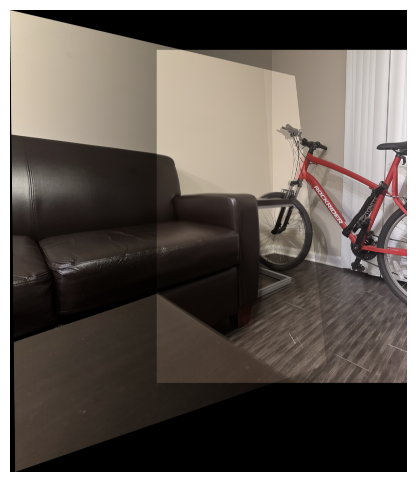

In [10]:
import cv2
import numpy as np

img1 = cv2.imread('./results/save_sittingroom_wrapl.png')
img2 = cv2.imread('./results/save_sittingroom_r.png')  

def blend_images(img1, img2):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    rows, cols, _ = img1.shape
    alpha_mask1 = np.tile(np.linspace(1, 0, cols), (rows, 1)).astype(np.float32) # alpha mask
    alpha_mask2 = np.tile(np.linspace(0, 1, cols), (rows, 1)).astype(np.float32)

    img1_blended = cv2.merge([alpha_mask1, alpha_mask1, alpha_mask1]) * img1
    img2_blended = cv2.merge([alpha_mask2, alpha_mask2, alpha_mask2]) * img2

    blended_image = img1_blended + img2_blended

    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)
    return blended_image

result = blend_images(img1, img2)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# 1.4.2 Laplacian

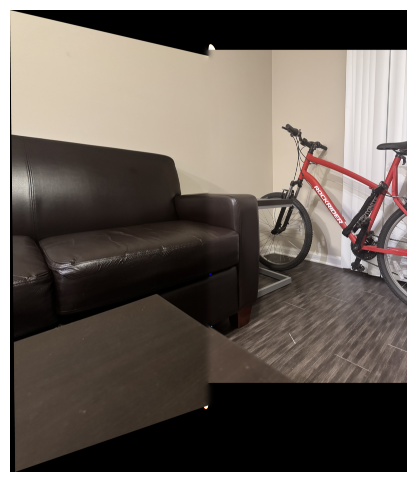

In [12]:
import cv2
import numpy as np

def build_gaussian_pyramid(img, levels):
    gaussian_pyramid = [img]
    for i in range(levels):
        img = cv2.pyrDown(img)
        gaussian_pyramid.append(img)
    return gaussian_pyramid

def build_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        next_level = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=(gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid[i], next_level)
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])  # The smallest level remains the same
    return laplacian_pyramid

def blend_pyramids(laplacianA, laplacianB, mask_pyramid):
    blended_pyramid = []
    for la, lb, mask in zip(laplacianA, laplacianB, mask_pyramid):
        # Expand the mask to have three channels
        mask_3ch = cv2.merge([mask, mask, mask])
        blended = la * mask_3ch + lb * (1.0 - mask_3ch)
        blended_pyramid.append(blended)
    return blended_pyramid

def reconstruct_from_pyramid(pyramid):
    img = pyramid[-1]
    for i in range(len(pyramid) - 2, -1, -1):
        img = cv2.pyrUp(img, dstsize=(pyramid[i].shape[1], pyramid[i].shape[0]))
        img = cv2.add(img, pyramid[i])
    return img

def laplacian_pyramid_blending(img1, img2, mask, levels=6):
    # Step 1: Build Gaussian pyramids for the images and the mask
    gpA = build_gaussian_pyramid(img1, levels)
    gpB = build_gaussian_pyramid(img2, levels)
    gpM = build_gaussian_pyramid(mask, levels)

    # Step 2: Build Laplacian pyramids for the images
    lpA = build_laplacian_pyramid(gpA)
    lpB = build_laplacian_pyramid(gpB)

    # Step 3: Blend each level of the Laplacian pyramids using the mask pyramid
    blended_pyramid = blend_pyramids(lpA, lpB, gpM)

    # Step 4: Reconstruct the image from the blended pyramid
    blended_img = reconstruct_from_pyramid(blended_pyramid)
    return blended_img


img1 = cv2.imread('./results/save_sittingroom_wrapl.png').astype(np.float32) / 255.0
img2 = cv2.imread('./results/save_sittingroom_r.png').astype(np.float32) / 255.0

rows, cols, _ = img1.shape
mask = np.zeros((rows, cols), dtype=np.float32)
mask[:, :cols // 2] = 1 
mask = cv2.GaussianBlur(mask, (21, 21), 0) 

blended_img = laplacian_pyramid_blending(img1, img2, mask)

blended_img = (blended_img * 255).astype(np.uint8)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



# Bonus

Homography matrix H:
[[ 6.66364842e-01  1.83571581e-03 -3.52592692e+01]
 [-1.47399039e-01  4.67531326e-01 -5.70909559e+00]
 [-2.75652281e-03 -1.95260541e-05  1.00000000e+00]]


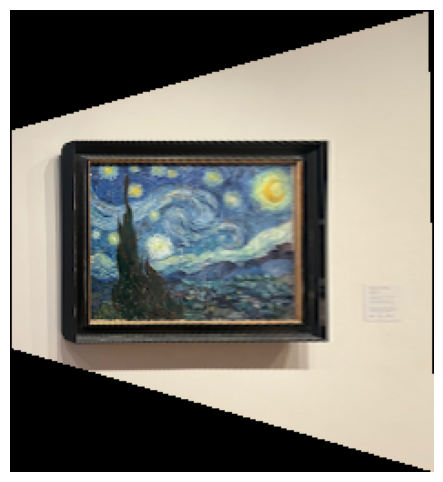

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def compute_homography(image1points, image2points):
    num_points = image1points.shape[0]
    A = []
    for i in range(num_points):
        x, y = image1points[i][0], image1points[i][1]
        x_prime, y_prime = image2points[i][0], image2points[i][1]

        A.append([-x, -y, -1,  0,  0,  0, x_prime * x, x_prime * y, x_prime])
        A.append([ 0,  0,  0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

    A = np.array(A)

    U, S, Vt = np.linalg.svd(A) # SVD to solve the total_least_squares problem
    h = Vt[-1] # smallest eigenvalue
    H = h.reshape(3, 3) # reshape
    H = H / H[2, 2] # Normalize

    return H

def perspective_transform(points, H):
    num_points = points.shape[0]
    homogeneous_points = np.hstack((points, np.ones((num_points, 1))))
    transformed_points = H @ homogeneous_points.T  # [3, N]
    transformed_points = transformed_points[:2, :] / transformed_points[2, :] # Normalize
    return transformed_points.T

def warp_image(image, image_b, H):
    h, w = image.shape[:2] # Shape
    h2, w2, _ = image_b.shape
    corners = np.array([ # four corners
        [0, 0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]
    ], dtype=np.float32)

    transformed_corners = perspective_transform(corners, H) # for output

    x_min, x_max = transformed_corners[:, 0].min(), max(transformed_corners[:, 0].max(), w2)
    y_min, y_max = transformed_corners[:, 1].min(), max(transformed_corners[:, 1].max(), h2)
    output_width = int(np.ceil(x_max - x_min))
    output_height = int(np.ceil(y_max - y_min))

    translation_matrix = np.array([ # make sure all the locations are positive
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])
    H_translated = translation_matrix @ H  
    
    warped_image = np.zeros((output_height, output_width, 3), dtype=np.uint8)

    x_coords, y_coords = np.meshgrid(np.arange(output_width), np.arange(output_height))
    homogeneous_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords).ravel()])

    # Reverse
    H_inv = np.linalg.inv(H_translated)
    source_coords = H_inv @ homogeneous_coords
    source_coords /= source_coords[2]  # Norm

    src_x = source_coords[0].reshape(output_height, output_width)
    src_y = source_coords[1].reshape(output_height, output_width)

    map_x = src_x.ravel()
    map_y = src_y.ravel()
    
    # Interpolation for all three RGB channels
    for i in range(3):  
        warped_image[..., i] = map_coordinates(image[..., i], [map_y, map_x], order=1, mode='constant', cval=0).reshape(output_height, output_width)

    return warped_image

# Load images
factor = 1.5
ori_h, ori_w = 73.7 * factor, 92.1 * factor 
img1 = cv2.imread('./bonus.jpeg')
img2 = np.zeros((int(ori_h), int(ori_w), 3), dtype=np.uint8)

# Convert img1 from BGR to RGB for consistency in display and processing
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# # Select points on the image
# plt.imshow(img1)
# plt.title('Click at least 4 points on Image 1')
# image1points = np.array(plt.ginput(n=-1, timeout=0))
# plt.close()


image1points = np.array([[ 52.83333333,  28.86796537],
 [165.31818182,  64.33116883],
 [164.76406926, 192.33116883],
 [ 52.27922078, 230.01082251]])

# Define destination points in the second image
image2points = np.array([
    [0, 0],
    [ori_w, 0],
    [ori_w, ori_h],
    [0, ori_h]
])

# Compute the homography matrix
H = compute_homography(image1points, image2points)
print('Homography matrix H:')
print(H)

# Warp image using computed homography
warped_image = warp_image(img1, img2, H)

# Display and save the result
plt.figure(figsize=(6, 6))
plt.imshow(warped_image)
plt.axis('off')
plt.show()

# Save the warped image in RGB format
# plt.imsave('./warped_bonus.png', warped_image)
